In [57]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

df = pd.read_csv("final_dataset.csv")

cleaned_extensions = []
for index,row in df.iterrows(): 
    temp_list=[]
    s=row['fileextensions']
    s = s.replace("np.str_", "")   
    real_list = ast.literal_eval(s)
    # print(type(real_list))
    for ele in real_list:
        temp_list.append(ele)
    cleaned_extensions.append(temp_list)
df['fileextensions'] = cleaned_extensions


df['day']= df['timeofcommit'].str.split().str[0]
df['hour']= df['timeofcommit'].str.split().str[1].str.split(":").str[0].astype(int)


bins=[0,6,12,18,24]
labels=["night","morning","afternoon","evening"]

df['time_bin']=pd.cut(df['hour'],bins=bins,labels=labels,right=False)

bins   = [0, 10, 50, 200, 1000, df['linesadded'].max()]
labels = ["tiny", "small", "medium", "large", "huge"]

df['linesadded_bin'] = pd.cut(df['linesadded'], bins=bins, labels=labels, right=True)

bins   = [0, 10, 50, 200, 1000, df['linesdeleted'].max()]
labels = ["tiny","small","medium","large","huge"]
df['linesdeleted_bin'] = pd.cut(df['linesdeleted'], bins=bins, labels=labels, right=True)

#Binning is not that useful but as we have the log transoform of the values I am trying out a hybrid method to have both bins and log transforms.

df['linesadded_log']   = np.log1p(df['linesadded'])
df['linesdeleted_log'] = np.log1p(df['linesdeleted'])
df['fileschanged_log'] = np.log1p(df['numfileschanged'])
df['comments_log']     = np.log1p(df['numcommentsadded'])

df.drop(columns=['timeofcommit','hour','linesadded','linesdeleted','numfileschanged','numcommentsadded'],inplace=True)

df['net_churn'] = df['linesadded_log'] - df['linesdeleted_log']   # growth vs shrink
df['add_delete_ratio'] = df['linesadded_log'] / (df['linesdeleted_log'] + 1e-6)

#Scope Features
df['files_per_line'] = (df['fileschanged_log'] + 1) / (
    df['linesadded_log'] + df['linesdeleted_log'] + 1e-6
)


line_order=["tiny","small","medium","large","huge"]

ord_enc= OrdinalEncoder(categories=[line_order,line_order])

df[['linesadded_bin','linesdeleted_bin']]=ord_enc.fit_transform(df[['linesadded_bin','linesdeleted_bin']])


df_time = pd.get_dummies(df['time_bin'])
df=pd.concat([df,df_time],axis=1)

df_day=pd.get_dummies(df['day'])
df=pd.concat([df,df_day],axis=1)

df_type=pd.get_dummies(df['committype'])
df = pd.concat([df,df_type],axis=1)

df.drop(columns=['time_bin','day','index','committype'], inplace=True)


The first step of this notebook will be to pick up what we learnt in the EDA notebook and preprocess it accordingly as done above


In [58]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

file_ext = mlb.fit_transform(df['fileextensions'])

file_df = pd.DataFrame(file_ext,columns=mlb.classes_, index=df.index)

df = pd.concat([df,file_df],axis=1)
df.drop(columns=['fileextensions'],inplace=True)

In the previous notebook, we had exploded the filextension column for better visualization. In this notebook however our aim is to get the dataset ready for our model and thus we cannot explode it. To tackle this we have used a multi label Binarizer which assigns binary value to each file extension type. Generally this would be problematic as this would increase dimensions by a lot making the model too complex. However, in this case there a 10 unique file extensions so adding 10 more columns to the datset in not an issue as done in the above cell.

In [59]:
df

,role,commitmessage,linesadded_bin,linesdeleted_bin,linesadded_log,linesdeleted_log,fileschanged_log,comments_log,net_churn,add_delete_ratio,files_per_line,night,morning,afternoon,evening,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,bugfix,feature,refactor,test,css,html,java_go,js_ts,md,py,sql,test_js,test_py,yml_json
0,frontend,"""Implement responsive UI component with dropdo...",3.0,2.0,5.746203,4.615121,1.609438,1.098612,1.131083,1.245082,0.251844,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,0,0,0,1,0,0,0,0,0,0
1,frontend,"""Refactor UI components: Implement responsive ...",2.0,2.0,5.257495,4.317488,1.609438,1.098612,0.940007,1.217721,0.272527,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,1,0,0,0,0,0,0,0,0,0
2,fullstack,"""feat: Implement responsive UI layout with mod...",3.0,2.0,5.620401,4.990433,1.609438,1.609438,0.629968,1.126235,0.245922,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,0,1,0,0,0,0,0,0,0,0
3,frontend,"""Refactored UI components for responsive layou...",3.0,2.0,5.505332,5.105945,1.609438,1.098612,0.399386,1.078220,0.245912,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,0,0,0,1,0,0,0,0,0,0
4,fullstack,"""feat: Implement responsive UI layout for logi...",3.0,3.0,6.541030,5.937536,1.098612,1.791759,0.603494,1.101640,0.168177,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,fullstack,"""Implement responsive UI layout for login page...",3.0,3.0,6.238325,5.652489,1.791759,1.791759,0.585835,1.103642,0.234783,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,1,0,1,0,0,0,0,0,0,0
1496,fullstack,Implement responsive UI improvements for login...,3.0,2.0,5.676754,5.081404,1.945910,1.386294,0.595349,1.117162,0.273830,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,0,0,0,1,0,0,0,0,0,0
1497,backend,Fixed authentication logic for API login endpo...,3.0,2.0,5.568345,4.962845,1.098612,1.945910,0.605500,1.122006,0.199276,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,0,0,0,0,0,0,1,0,0,0
1498,frontend,Implemented responsive modal dropdown componen...,1.0,0.0,3.295837,2.079442,0.693147,1.609438,1.216395,1.584962,0.314988,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,1,0,0,0,0,0,0,0,0,0


In [60]:
X=df['role']
print(len(X))

1500


In the EDA notebook we did not touch the commitmessages column. This column however is of much importance. Many NLP tasks only use one column of this type to classify fields. So, this has to be used in the right way as it will infulence our results significantly.

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
df_try=df.copy()
encoder = LabelEncoder()
y=df_try['role']
y=encoder.fit_transform(y)
X=df_try.drop(columns=['role'])
print(len(X),len(y))
cv=CountVectorizer(max_features=4000)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

X_text_train=cv.fit_transform(X_train['commitmessage'])
X_text_test=cv.transform(X_test['commitmessage'])


X_text_train_df = pd.DataFrame(X_text_train.toarray(), 
                               columns=cv.get_feature_names_out(), 
                               index=X_train.index)
X_text_test_df = pd.DataFrame(X_text_test.toarray(), 
                              columns=cv.get_feature_names_out(), 
                              index=X_test.index)


X_train_num = X_train.drop(columns=['commitmessage'])
X_test_num  = X_test.drop(columns=['commitmessage'])


X_train_final = pd.concat([X_train_num, X_text_train_df], axis=1)
X_test_final  = pd.concat([X_test_num,  X_text_test_df],  axis=1)

print(X_train_final.shape, X_test_final.shape)

print(len(X_test))

1500 1500
(1200, 1207) (300, 1207)
300


In the above cell, I have used a simple Bag of Words(BOW) technique to convert the textual data into vectors. The BOW model  creates a vocabulary of all unqiue words in the dataset, and message is shown as a vector whose entries are the word count of that particular word. Thus, the size of the vector is the size of the vocab

In [62]:
X_train_final.columns

Index(['linesadded_bin', 'linesdeleted_bin', 'linesadded_log',
       'linesdeleted_log', 'fileschanged_log', 'comments_log', 'net_churn',
       'add_delete_ratio', 'files_per_line', 'night',
       ...
       'witnessed', 'work', 'working', 'works', 'world', 'would', 'yaml',
       'yesterday', 'yml', 'yml_json'],
      dtype='object', length=1207)

In [63]:
(X_train_final[['net_churn','linesadded_log','linesdeleted_log',
           'fileschanged_log','comments_log']] < 0).sum()


net_churn           4
linesadded_log      0
linesdeleted_log    0
fileschanged_log    0
comments_log        0
dtype: int64

In [64]:
X_train_final['net_churn_shifted'] = X_train_final['net_churn'] - X_train_final['net_churn'].min()
X_test_final['net_churn_shifted'] = X_test_final['net_churn'] - X_test_final['net_churn'].min()



In [65]:
(X_train_final[['net_churn','linesadded_log','linesdeleted_log',
           'fileschanged_log','comments_log']] < 0).sum()


net_churn           4
linesadded_log      0
linesdeleted_log    0
fileschanged_log    0
comments_log        0
dtype: int64

I chose Naive Bayes (GaussianNB) as one of the baseline models because it is widely used in text classification tasks due to its simplicity and efficiency. The key assumption it makes is that features are conditionally independent given the class label, which, although not always true in practice, often works surprisingly well for high-dimensional data like commit message vectors. This makes Naive Bayes a natural baseline to compare against more complex models.

In [66]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_final,y_train)

,priors,None
,var_smoothing,1e-09


In [67]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score
y_pred1 = gnb.predict(X_test_final)
accuracy_score(y_test,y_pred1)

0.6166666666666667

Macro F1: 0.630133659307272
              precision    recall  f1-score   support

     backend       1.00      0.54      0.70       110
    frontend       0.90      0.23      0.37        81
   fullstack       0.29      0.96      0.45        49
          qa       1.00      1.00      1.00        60

    accuracy                           0.62       300
   macro avg       0.80      0.68      0.63       300
weighted avg       0.86      0.62      0.63       300



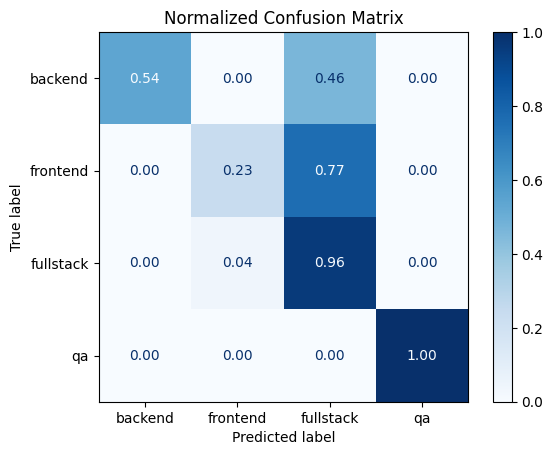

In [ ]:


macro_f1 = f1_score(y_test, y_pred1, average='macro')

print("Macro F1:",macro_f1)

print(classification_report(y_test, y_pred1, target_names=encoder.classes_))

cm = confusion_matrix(y_test, y_pred1, normalize='true')  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix")
plt.show()

For my first try, I used a Gaussian Naive Bayes model and it gave an accuracy of about 62% with a macro F1 of 0.63. The model worked very well for QA commits and was decent for backend, but it struggled with frontend and fullstack. In particular,it predicted many commits as fullstack even when they were not, which shows low precision. This is expected since Naive Bayes is a very basic model and assumes features are independent, but it still gives me a good starting point to compare with better models.

After trying Gaussian Naive Bayes as a starting point, we move to MultinomailNB which is more commonly used in text classification tasks. Unlike GaussianNB, which assumes continuous features follow a normal distribution, MultinomialNB works better with discrete count based features such as Bag of Words. Since my dataset includes commit messages that were vectorized into word counts, this model is a natural fit and should help capture patterns in the text more effectively.

In [74]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_final.drop(columns=['net_churn']),y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [75]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score
y_pred2 = mnb.predict(X_test_final.drop(columns=['net_churn']))
accuracy_score(y_test,y_pred2)

0.9766666666666667

Macro F1: 0.970414201183432
              precision    recall  f1-score   support

     backend       1.00      1.00      1.00       110
    frontend       0.92      1.00      0.96        81
   fullstack       1.00      0.86      0.92        49
          qa       1.00      1.00      1.00        60

    accuracy                           0.98       300
   macro avg       0.98      0.96      0.97       300
weighted avg       0.98      0.98      0.98       300



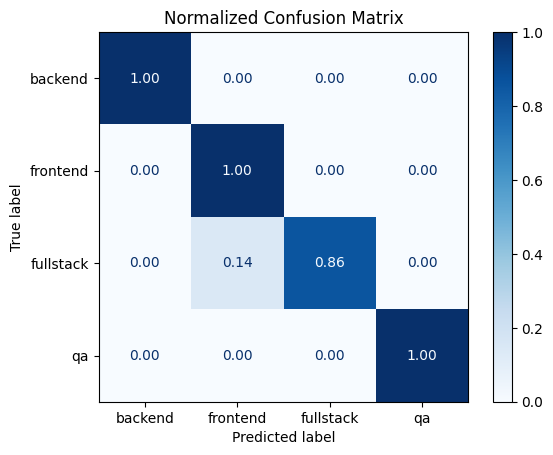

In [ ]:


macro_f1 = f1_score(y_test, y_pred2, average='macro')

print("Macro F1:",macro_f1)

print(classification_report(y_test, y_pred2, target_names=encoder.classes_))

cm = confusion_matrix(y_test, y_pred2, normalize='true')  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix")
plt.show()

Using MultinomialNB gives us way better results compared to GaussianNB. The model reaches about 98% accuracy with a macro F1 of 0.97, which is very close to the best-performing models. It classifies backend and QA perfectly, while frontend and fullstack also show very strong performance with only a small drop in precision/recall. This makes sense because MultinomialNB is designed for text data and works well with Bag of Words features. Overall, this shows that the commit messages themselves are highly influential, and text-based models achieve very high performance.

To try and check if only text column makes a differnce let us design a model with X as only the vectorized messages and y as the predictions

In [78]:
X_messages = df_try['commitmessage']
y_messages=df['role']
cv_text = CountVectorizer()

X_messages_train,X_messages_test,y_messages_train,y_messages_test=train_test_split(X_messages,y_messages,test_size=0.2,random_state=1)
X_messages_train=cv.fit_transform(X_messages_train)
X_messages_test=cv.transform(X_messages_test)




In [79]:
mlb_text = MultinomialNB()
mlb_text.fit(X_messages_train,y_messages_train)


,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


Macro F1: 0.9660130718954248
              precision    recall  f1-score   support

     backend       1.00      1.00      1.00       110
    frontend       0.91      1.00      0.95        81
   fullstack       1.00      0.84      0.91        49
          qa       1.00      1.00      1.00        60

    accuracy                           0.97       300
   macro avg       0.98      0.96      0.97       300
weighted avg       0.98      0.97      0.97       300



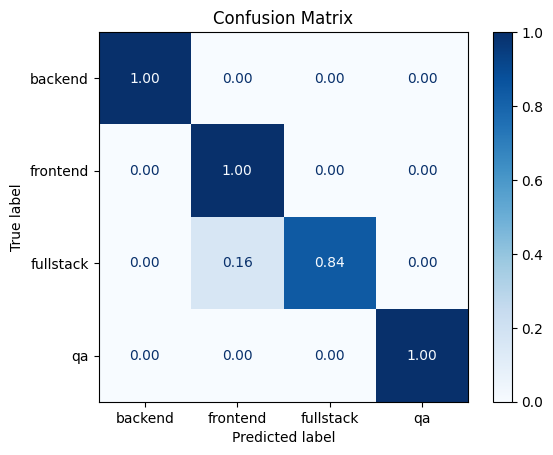

In [82]:
y_pred3 = mlb_text.predict(X_messages_test)


macro_f1 = f1_score(y_messages_test, y_pred3, average='macro')

print("Macro F1:",macro_f1)

print(classification_report(y_messages_test, y_pred3, target_names=encoder.classes_))

cm = confusion_matrix(y_messages_test, y_pred3, normalize='true')  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix")
plt.show()


The above results reflect that the commitmessage column alone is a very strong influencer and we get an accuracy of 97% by using just one column!

Lastly we will try an ensemble technique (RandomForest)to check if any better results can be observed.Random Forest is well suited here because it builds multiple decision trees and captures complex relationships between the columns,making it a strong contender here.

In [83]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
rf.fit(X_train_final,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:

y_pred4 = rf.predict(X_test_final)
accuracy_score(y_test,y_pred4)

0.9833333333333333

Macro F1: 0.9792663476874003
              precision    recall  f1-score   support

     backend       1.00      1.00      1.00       110
    frontend       0.95      0.99      0.97        81
   fullstack       0.98      0.92      0.95        49
          qa       1.00      1.00      1.00        60

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



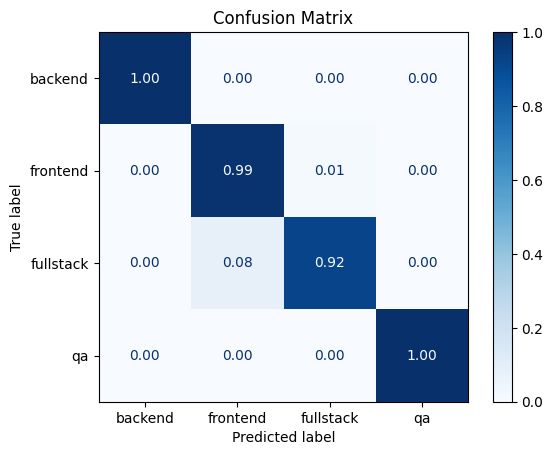

In [86]:

macro_f1 = f1_score(y_test, y_pred4, average='macro')

print("Macro F1:",macro_f1)

print(classification_report(y_test, y_pred4, target_names=encoder.classes_))

cm = confusion_matrix(y_test, y_pred4, normalize='true')  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix")
plt.show()


As expected, Random Forest gives the best results so far with an overall accuracy of 98% and a macro F1 of 0.98. The model classifies backend and QA commits perfectly and performs almost equally well for frontend and fullstack, with only minor drops in precision or recall. This improvement is reasonable since Random Forest is an ensemble method that captures complex relationships between both text-based and numeric features, unlike Naive Bayes which makes independent assumptions.These results show that combining multiple decision trees allows the model to balance across all roles more effectively.